# Assigment 2 
Group 7:
- Guillem Capellera
- Anna Oliveras
- Johnny Núñez

## Table of contents: FALTA CANVIAR L'INDEX
* [1. Import libraries](#import) 
* [2. Read and visualize the train and test files](#read)
* [3. Data distribution](#distribution)
* [4. Descriptors](#descriptors)
* [5. Hyperparameters](#hyper)
* [6. Bag of Visual Words](#BoVW)
* [7. KNN Classifier](#classifier)
* [8. Dimensionality reduction](#dim)
* [9. Experiments](#exp)
* [10. Test data evaluation](#test)

● We'll start with BoVW computed with Dense SIFT with a large enough codebook size  
● We'll normalize descriptors  
○ L2-norm, Power-norm, etc..  
● Spatial Pyramids  
● SVM and kernels  
○ Use sklearn standardScaler to project every dimension to [0, 1]!  
○ linear kernel  
○ RBF kernel  
○ our own histogram intersection kernel  
● OPTIONAL: Fisher Vectors (http://yael.gforge.inria.fr/tutorial/tuto_imgindexing.html)  

## 1. Import libraries

In [1]:

import cv2
import numpy as np
import pickle as pkl

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import normalize,  LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture as GMM


import matplotlib.pyplot as plt
from functools import partial
import time
import pandas as pd
from tqdm.notebook import trange, tqdm
import optuna
from optuna.visualization.matplotlib import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice, plot_pareto_front
import os
from optuna.samplers import TPESampler
import concurrent.futures
import gc
import seaborn as sns
from itertools import cycle
import random


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline


## 2. Read and visualize the train and test files <a name="read"></a>

In [2]:
train_images_filenames = pkl.load(
    open('MIT_split/train_images_filenames_unix.dat', 'rb'))
test_images_filenames = pkl.load(
    open('MIT_split/test_images_filenames_unix.dat', 'rb'))
# train_images_filenames = ['..' + n[15:] for n in train_images_filenames] original
# test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]  original
train_images_filenames = [n[16:] for n in train_images_filenames]
test_images_filenames = [n[16:] for n in test_images_filenames]
train_labels = pkl.load(open('MIT_split/train_labels_unix.dat', 'rb'))
test_labels = pkl.load(open('MIT_split/test_labels_unix.dat', 'rb'))


In [ ]:
# Function to visualize images of each class of the dataset
def visualize(images_filenames, labels, num_images=5):
    print(f'Number of samples: {len(images_filenames)}')
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    # set size for plot
    plt.figure(figsize=(15,8))
    # loop over classes
    for i, c in enumerate(classes):
        # get the first 5 images of the class
        idx = np.where(np.array(labels) == c)[0][:num_images]
        # loop over the images and plot them
        for j, index in enumerate(idx):
            plt_idx = j * num_classes + i + 1
            plt.subplot(num_images, num_classes, plt_idx)
            plt.imshow(cv2.cvtColor(cv2.imread(images_filenames[index]), cv2.COLOR_BGR2RGB))
            plt.axis('off')
            if j == 0:
                plt.title(c)

In [ ]:
# visualize the train dataset
visualize(train_images_filenames, train_labels)

In [ ]:
# visualize the test dataset
visualize(test_images_filenames, test_labels)

## 3. Data distribution <a name="distribution"></a>

In [ ]:
unique_classes, counts = np.unique(train_labels, return_counts=True)
total_count = sum(counts)
train_class_proportions = counts / total_count

# Calculate the class proportions for the test set
unique_classes, counts = np.unique(test_labels, return_counts=True)
total_count = sum(counts)
test_class_proportions = counts / total_count

# Print the class proportions for the train and test sets
print("Train set class proportions:", train_class_proportions)
print("Test set class proportions:", test_class_proportions)


In [ ]:
unique_labels = np.unique(train_labels + test_labels)
train_count = [np.sum(np.array(train_labels) == lab) for lab in unique_labels]
test_count = [np.sum(np.array(test_labels) == lab) for lab in unique_labels]


# distribution of the training and test set
def plot_distribution(train_count, test_count, unique_labels):
    plt.figure(figsize=(8, 5))
    plt.title("Distribution of the training and test set")
    plt.bar(unique_labels, train_count, label="Training Set")
    plt.bar(unique_labels, test_count, label="Test Set")
    plt.legend()
    plt.show()


plot_distribution(train_count, test_count, unique_labels)


## 4. Descriptors: DenseSIFT

In [ ]:
class DenseSIFT:
    def __init__(self, n_features=300, step_size=10): 
        self.extractor = cv2.SIFT_create() if n_features is None else cv2.SIFT_create(nfeatures=n_features)
        self.step_div_size = step_size

    def extract_features(self, image):
        kp = []
        init_step_size_x = max(image.shape[1] // self.step_div_size, 8)
        init_step_size_y = max(image.shape[0] // self.step_div_size, 8)
        current_step_x = init_step_size_x 
        current_step_y = init_step_size_y 
        avg_size = (current_step_x + current_step_y) // 2
        descriptors = [cv2.KeyPoint(x, y, avg_size) for y in range(0, image.shape[0], current_step_y) 
                                            for x in range(0, image.shape[1], current_step_x)]
        kpts, descriptors = self.extractor.compute(image, descriptors)
        return kpts, descriptors
    
    def extract_features_normalized(self, image):
        kp = []
        init_step_size_x = max(image.shape[1] // self.step_div_size, 8)
        init_step_size_y = max(image.shape[0] // self.step_div_size, 8)
        current_step_x = init_step_size_x 
        current_step_y = init_step_size_y 
        avg_size = (current_step_x + current_step_y) // 2
        descriptors = [cv2.KeyPoint(x, y, avg_size) for y in range(0, image.shape[0], current_step_y) 
                                            for x in range(0, image.shape[1], current_step_x)]
        kpts, descriptors = self.extractor.compute(image, descriptors)
        return np.array([(kpt.pt[0] / image.shape[0], kpt.pt[1] / image.shape[1]) + tuple(desc) for (kpt, desc) in zip(kpts, descriptors)])


In [ ]:
feature_extractors = {
    "DenseSIFT": DenseSIFT
}

In [ ]:
# Function to show the keypoints of an image given the image filename and using DenseSIFT class
def show_keypoints(img_path, descriptor=None, kp=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2)
    titles = ['Original_image',f'Keypoints:{len(kp)}']
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Example of keypoints of an image
img=cv2.imread(train_images_filenames[2])
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dense_kp = DenseSIFT(step_size=20).extract_features(gray)
show_keypoints(train_images_filenames[2], kp=dense_kp[0])

In [ ]:
# Function to extract the features of the images
def extract_features(filenames, labels, descriptor_extractor, extract_features=True):

    descriptors = []
    label_per_descriptor = []
    images = []
    
    for filename,labels in zip(filenames, labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if extract_features:
            des = descriptor_extractor.extract_features_normalized(gray)  # Here we have added [1] in order to obtain the descriptors
            descriptors.append(des)
        else:
            images.append(gray)
            
        label_per_descriptor.append(labels)

    if not extract_features:
        return images, label_per_descriptor
    else:
        return descriptors, label_per_descriptor


In [ ]:
# Function to cluster the features
def cluster_local_features(features, n_clusters):
    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=min(20*n_clusters, features.shape[0]),
                                compute_labels=False, reassignment_ratio=10**-4, random_state=42)
    codebook.fit(features)
    return codebook


## 5. Normalization

In [ ]:
# Function that normalizes an array x using L^2 norm
def l2_norm(x):
    norm = np.linalg.norm(x, ord=2)
    x_norm = x / norm
    return x_norm

# Function that normalizes an array x using power norm
def power_norm(x):
    x = np.sign(x) * np.abs(x) ** 0.5
    norm = np.linalg.norm(x, ord=2)
    x_norm = x / norm
    return x_norm

def no_norm(x):
    return x

# Dictionary with all normalization functions
norms = {"l2": l2_norm, "power": power_norm, "none": no_norm}

## 6. Spatial Pyramid

In [ ]:
def spatial_pyramid(divisions):

    size = np.sum([x*y for (x,y) in divisions])
    
    def iterate():
        for div in range(len(divisions)):
            rows, cols = divisions[div]
            for r in range(rows):
                for c in range(cols):
                    yield r/rows, c/cols, (r+1)/rows, (c+1)/cols
    return int(size), divisions, iterate

pyramid_divisions = {
    "1x1": spatial_pyramid([[1,1]]),
    "2x2": spatial_pyramid([[1,1],[2,2]]),
    "4x4": spatial_pyramid([[1,1],[2,2],[4,4]]),
    "horizontal 2x1": spatial_pyramid([[1,1], [2,1]]),
    "horizontal 3x1": spatial_pyramid([[1,1], [2,1], [3,1]]),
    "horizontal 4x1": spatial_pyramid([[1,1], [2,1], [4,1]]),
    "vertical 1x2": spatial_pyramid([[1,1], [1,2]]),
    "vertical 1x3": spatial_pyramid([[1,1], [1,2], [1,3]]),
    "vertical 1x4": spatial_pyramid([[1,1], [1,2], [1,4]])
}

pyramid = {
    "size": 0,
    "divisions": [],
    "iterate": lambda : None
}

In [ ]:
# pyramid = pyramid_divisions["horizontal 3x1"]
# print("Number of divisions: ", pyramid.size())
# print("Divisions: ", pyramid.get_divisions())

# for (x0,y0,x,y) in pyramid:
#     print(f'({x0:.2f}, {y0:.2f}, {x:.2f}, {y:.2f})')

pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]
print("Number of divisions: ", pyramid["size"])
print("Divisions: ", pyramid["divisions"])

for (x0,y0,x,y) in pyramid["iterate"]():
    print(f'({x0:.2f}, {y0:.2f}, {x:.2f}, {y:.2f})')


In [ ]:
# Function that given img_path and pyramid, plots the image with the patches drawed with rectangles at each level using the pyramid["iterate"]() function
def split_image(img_path, pyramid):
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Number of levels to plot
    num_images = len(pyramid["divisions"])
    fig,axes = plt.subplots(1,num_images, figsize=(2*num_images,2))

    # Compute the patches of each level in a list
    rectangles = list(pyramid["iterate"]())

    num_patches = 0
    for i,div in enumerate(pyramid["divisions"]):
        img_copy= img.copy()
        rows = div[0]
        cols = div[1]
        for (y0,x0,y,x) in rectangles[num_patches:rows*cols+num_patches]: 
            cv2.rectangle(img_copy, (int(x0*img_copy.shape[1]), int(y0*img_copy.shape[0])), (int(x*img_copy.shape[1]), int(y*img_copy.shape[0])), (0,255,0), 2)
            num_patches += 1
        axes[i].imshow(img_copy)
        axes[i].set_title(f'{rows}x{cols}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()



In [ ]:
pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["4x4"]
split_image(train_images_filenames[2], pyramid)


In [ ]:
pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]
split_image(train_images_filenames[2], pyramid)

## 7. Histograms, BoVW Classifier and Cross Validation

In [ ]:
# Adapt the function to be able to modify the normalization type 
def compute_histogram(assigned_clusters, num_clusters, normalization = norms["l2"]):
    bag_visual_words = np.zeros(
        (len(assigned_clusters), num_clusters), dtype=np.float32)

    for i in range(len(assigned_clusters)):
        hist_i, _ = np.histogram(
            assigned_clusters[i], bins=num_clusters, range=(0, num_clusters))
        bag_visual_words[i, :] = normalization(hist_i) 

    return bag_visual_words


# Function based on obtain_histogram_visual_words but adding the functionality of constructing spatial pyramid histograms
def obtain_spatial_histogram_visual_words(features, position_features, tr_lengths=None, codebook=None, normalization = norms["l2"], pyramid = None):

    if tr_lengths is None:
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)

    assigned_labels = codebook.predict(features)

    lengths = np.array([0]+[descriptor_length for descriptor_length in tr_lengths])
    lengths = np.cumsum(lengths)

    splitted_labels = [assigned_labels[lengths[i]:lengths[i+1]] for i in range(len(lengths)-1)]
    
    if pyramid is None:
        return compute_histogram(splitted_labels, codebook.cluster_centers_.shape[0], normalization = normalization)

    num_clusters = codebook.cluster_centers_.shape[0]
    histograms = np.zeros((len(splitted_labels), num_clusters*pyramid["size"]), dtype=np.float32)
    
    def get_positions(position_features, x0, y0, x, y):
        return np.where((position_features[:,0] >= x0) & (position_features[:,1] >= y0) & (position_features[:,0] < x) & (position_features[:,1] < y))

    num_patches = 0
    for (x0,y0,x,y) in list(pyramid["iterate"]()):
        # Get the labels of the features that are in the current division
        splitted_labels = [assigned_labels[lengths[i]:lengths[i+1]][get_positions(position_features[lengths[i]:lengths[i+1]],x0,y0,x,y)] for i in range(len(lengths)-1)]
        # Compute the histogram of the current division
        histograms[:, num_patches*num_clusters:(num_patches+1)*num_clusters] = compute_histogram(splitted_labels, num_clusters, normalization = normalization)
        num_patches += 1

    return histograms

# Function to compute the intersection of two arrays of concatenated histograms

def histogram_intersection(h1, h2):
    kernel = np.zeros((h1.shape[0], h2.shape[0]))

    for i in range(h1.shape[0]):
        col1 = h1[:, i].reshape(-1, 1)
        col2 = h2[:, i].reshape(-1, 1)
        kernel += np.minimum(col1, col2.T)
    return kernel

# els altres kernels simplement li passes com a parametre del classifier "linear" o "rbf"
# --> parametres a optimitzar: C penalty and gamma coefficient

In [ ]:
# Define cross-validation functions
cv_strategies = {
    "kfold": KFold,
    "stratified": StratifiedKFold,
    "repeats": RepeatedStratifiedKFold
}

metrics = {
    "balanced_accuracy": balanced_accuracy_score,
    "accuracy": accuracy_score,
    "f1-score": f1_score,
    "confusion-matrix": confusion_matrix
}

class BoVWClassifier(BaseEstimator, ClassifierMixin):
    """ Image classifier using Bag of Visual Words. """

    def __init__(self, clustering_method, classifier, reduction_method, normalization, spatial_pyramid_div = None):
        self.clustering_method = clustering_method
        self.classifier = classifier
        self.reduction_method = reduction_method
        self.codebook = None
        self.normalization = normalization
        self.spatial_pyramid_div = spatial_pyramid_div

    def fit(self, features, labels, sample_weight=None):
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:]
        self.codebook = self.clustering_method(features)
        
        tr_hist = obtain_spatial_histogram_visual_words(
            features, position_features, tr_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)

        tr_hist_reduced = self.reduction_method.fit_transform(tr_hist, labels)

        #Standardize features by removing the mean and scaling to unit variance.
        self.scaler = StandardScaler()
        tr_hist_reduced = self.scaler.fit_transform(tr_hist_reduced)
       
        self.classifier.fit(tr_hist_reduced, labels)

    def fit_transform(self, features, labels):
        self.fit(features, labels)
        return self.predict(features)

    def predict_proba(self, features):
        features = features[1]
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:]

        te_hist = obtain_spatial_histogram_visual_words(
            features, position_features, te_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        te_hist_reduced = self.scaler.transform(te_hist_reduced)
        cls = self.classifier.predict_proba(te_hist_reduced)
        return cls

    def predict(self, features):
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:] 

        te_hist = obtain_spatial_histogram_visual_words(
            features, position_features, te_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        te_hist_reduced = self.scaler.transform(te_hist_reduced)
        cls = self.classifier.predict(te_hist_reduced)
        return cls

    def score(self, X, y=None):
        return (sum(self.predict(X)))

    def score_accuracy(self, X, y):
        return 100*self.score(X, y)/len(y)


class FastCrossValidator:
    """ Cross-validator class """

    def __init__(self, cv_method, metric_name, trainer, labels):
        """ 
        Params:
        - cv_method (function): Clustering function that when called returns a codebook.
        - classifier (Classifier like KNN, LogisticRegression,...)
        - reduction_method (None/PCA/LDA/Isomap)
        """
        self.cv_method = cv_method
        self.metric_name = metric_name
        self.trainer = trainer
        self.labels = np.array(labels)

    def cross_validate(self, feature_list, labels, n_jobs=-1):
        return cross_val_score(self.trainer, feature_list, labels, scoring=self.metric_name, cv=self.cv_method, n_jobs=n_jobs)


class Dummy():
    """ Dummy dimensionality reduction method that keeps all the original features. """

    def fit_transform(self, features, labels):
        return features

    def transform(self, features):
        return features


classifiers = {"KNN": KNeighborsClassifier,
               "svm": SVC}

dim_reduction = {
    "None": Dummy,
    "PCA": PCA,
    "LDA": LinearDiscriminantAnalysis,
}

kernels = {"linear": 'linear', "RBF": 'rbf', "histogram_intersection": histogram_intersection}

## 8. Results week 1
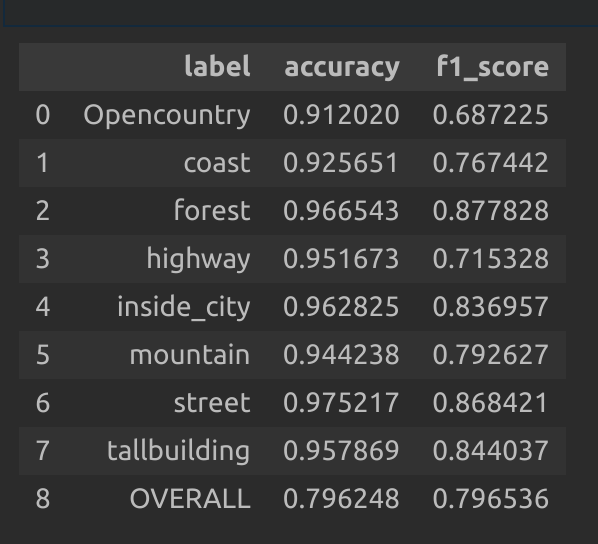

## 9. Experiments

### 9.1 DenseSIFT paramerters

In [ ]:
def compare_models(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)
    n_features = int(trial.suggest_int('n_features', 100, 300))
    step_size = int(trial.suggest_int('step_size', 2, 75))
    
    DESCRIPTOR = feature_extractors["DenseSIFT"](n_features=n_features,
        step_size=step_size)

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=1024) 
    reduction_method = dim_reduction["None"]()
    classifier = classifiers["svm"](kernel=kernels["RBF"], C=1, gamma=0.01, probability=True)
    normalization = norms["l2"]
    pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]
    
    ex_trainer = BoVWClassifier(clustering, classifier, reduction_method, normalization, pyramid)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="DenseSIFT", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="DenseSIFT",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_models, n_trials=100, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("densesift.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

### Create a pkl with the best parameters for DenseSIFT

In [ ]:
best_n_features = 214
best_step_size = 15

DESCRIPTOR = feature_extractors["DenseSIFT"](n_features=best_n_features,
        step_size=best_step_size)

train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

with open('train_descriptors.pkl', 'wb') as f:
    pkl.dump(train_descriptors, f)
with open('train_labels_descrip.pkl', 'wb') as f:
    pkl.dump(train_labels_descrip, f)
with open('test_descriptors.pkl', 'wb') as f:
    pkl.dump(test_descriptors, f)
with open('test_labels_descrip.pkl', 'wb') as f:
    pkl.dump(test_labels_descrip, f)

### 9.2 Number of codebook clusters

In [ ]:
#  TODO
def compare_n_clusters(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)

    # Load the pkls with the descriptors and labels
    with open('train_descriptors.pkl', 'rb') as f:
        train_descriptors = pkl.load(f)
    with open('train_labels_descrip.pkl', 'rb') as f:
        train_labels_descrip = pkl.load(f)
    with open('test_descriptors.pkl', 'rb') as f:
        test_descriptors = pkl.load(f)
    with open('test_labels_descrip.pkl', 'rb') as f:
        test_labels_descrip = pkl.load(f)
    

    n_clusters = int(trial.suggest_categorical(
        'n_clusters', [64, 128, 256, 512, 1024]))

    clustering = partial(cluster_local_features, n_clusters=n_clusters) 
    reduction_method = dim_reduction["None"]()
    classifier = classifiers["svm"](kernel=kernels["RBF"], C=1, gamma=0.01, probability=True)
    normalization = norms["l2"]
    pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]
    
    ex_trainer = BoVWClassifier(clustering, classifier, reduction_method, normalization, pyramid)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="compare_n_clusters", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="compare_n_clusters",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_n_clusters, n_trials=10, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("n_clusters.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

In [ ]:
plot_optimization_history(study)

### 9.3 Dimension reduction

In [ ]:
def compare_dimensionality(trial):
    try:
        search_metric = "balanced_accuracy"
        cv_strategy = cv_strategies["stratified"](n_splits=10)

        # Load the pkls with the descriptors and labels
        with open('train_descriptors.pkl', 'rb') as f:
            train_descriptors = pkl.load(f)
        with open('train_labels_descrip.pkl', 'rb') as f:
            train_labels_descrip = pkl.load(f)
        with open('test_descriptors.pkl', 'rb') as f:
            test_descriptors = pkl.load(f)
        with open('test_labels_descrip.pkl', 'rb') as f:
            test_labels_descrip = pkl.load(f)
        

        dimensionality_reduction = trial.suggest_categorical(
            'dimensionality_reduction', ["PCA", "LDA"])
        n_components = int(trial.suggest_int('n_components', 1, 100))

        clustering = partial(cluster_local_features, n_clusters=128) 
        reduction_method = dim_reduction[dimensionality_reduction](n_components=n_components)
        classifier = classifiers["svm"](kernel=kernels["RBF"], C=1, gamma=0.01, probability=True)
        normalization = norms["l2"]
        pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]
        
        ex_trainer = BoVWClassifier(clustering, classifier, reduction_method, normalization, pyramid)
        ex_cv = FastCrossValidator(
            cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
        ex_metrics = ex_cv.cross_validate(
            train_descriptors, train_labels_descrip, n_jobs=8)

        return ex_metrics.mean()
    except:
        return 0



# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="Dimensionality_Reduction", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="Dimensionality_Reduction",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_dimensionality, n_trials=10, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("compare_dimensionality.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

### 9.4 Normalization

In [ ]:
def compare_normalization(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)

    # Load the pkls with the descriptors and labels
    with open('train_descriptors.pkl', 'rb') as f:
        train_descriptors = pkl.load(f)
    with open('train_labels_descrip.pkl', 'rb') as f:
        train_labels_descrip = pkl.load(f)
    with open('test_descriptors.pkl', 'rb') as f:
        test_descriptors = pkl.load(f)
    with open('test_labels_descrip.pkl', 'rb') as f:
        test_labels_descrip = pkl.load(f)
    
    norm_type = trial.suggest_categorical(
        'normalization', ["l2", "power", "none"])

    clustering = partial(cluster_local_features, n_clusters=128) 
    reduction_method = dim_reduction["None"]()
    classifier = classifiers["svm"](kernel=kernels["RBF"], C=1, gamma=0.01, probability=True)
    normalization = norms[norm_type]
    pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]
    
    ex_trainer = BoVWClassifier(clustering, classifier, reduction_method, normalization, pyramid)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()




# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="normalization", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="normalization",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_n_clusters, n_trials=10, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("normalization.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

### 9.5 Spatial pyramid

In [ ]:
def compare_spatial_pyramid(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)

    # Load the pkls with the descriptors and labels
    with open('train_descriptors.pkl', 'rb') as f:
        train_descriptors = pkl.load(f)
    with open('train_labels_descrip.pkl', 'rb') as f:
        train_labels_descrip = pkl.load(f)
    with open('test_descriptors.pkl', 'rb') as f:
        test_descriptors = pkl.load(f)
    with open('test_labels_descrip.pkl', 'rb') as f:
        test_labels_descrip = pkl.load(f)
    
    spatial_pyramid = trial.suggest_categorical(
        'spatial_pyramid', ["1x1", "2x2", "4x4", "horizontal 2x1", "horizontal 3x1", "horizontal 4x1", "vertical 1x2", "vertical 1x3", "vertical 1x4" ])

    clustering = partial(cluster_local_features, n_clusters=128) 
    reduction_method = dim_reduction["None"]()
    classifier = classifiers["svm"](kernel=kernels["RBF"], C=1, gamma=0.01, probability=True)
    normalization = norms["l2"]
    pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions[spatial_pyramid]
    
    ex_trainer = BoVWClassifier(clustering, classifier, reduction_method, normalization, pyramid)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()




# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="spatial_pyramid", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="spatial_pyramid",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_spatial_pyramid, n_trials=10, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("spatial_pyramid.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

### 9.6 SVM hyperparameters and kernels

In [ ]:
def compare_svm(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)

    # Load the pkls with the descriptors and labels
    with open('train_descriptors.pkl', 'rb') as f:
        train_descriptors = pkl.load(f)
    with open('train_labels_descrip.pkl', 'rb') as f:
        train_labels_descrip = pkl.load(f)
    with open('test_descriptors.pkl', 'rb') as f:
        test_descriptors = pkl.load(f)
    with open('test_labels_descrip.pkl', 'rb') as f:
        test_labels_descrip = pkl.load(f)

    kernel_type = trial.suggest_categorical(
        'kernel', ["linear", "RBF", "histogram_intersection" ])
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e3)
    probability = trial.suggest_categorical(
        'probability', [True, False])


    clustering = partial(cluster_local_features, n_clusters=128) 
    reduction_method = dim_reduction["None"]()
    classifier = classifiers["svm"](kernel=kernels[kernel_type], C=C, gamma=gamma, probability=probability)
    normalization = norms["l2"]
    pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]
    
    ex_trainer = BoVWClassifier(clustering, classifier, reduction_method, normalization, pyramid)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()




# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="svm", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="svm",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_svm, n_trials=10, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("svm.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

## 10. Test of the Best Model

In [ ]:
# Best descriptor
DESCRIPTOR = feature_extractors["DenseSIFT"](n_features=251, patch_size=3, step_size=75)
train_descriptors, train_labels_descrip = extract_features(train_images_filenames, train_labels, DESCRIPTOR)
test_descriptors, test_labels_descrip = extract_features(test_images_filenames, test_labels, DESCRIPTOR)

In [ ]:
# Trial
clustering = partial(cluster_local_features, n_clusters=1024) 
reduction_method = dim_reduction["PCA"](n_components=46)
# classifier = classifiers["KNN"](n_neighbors=18, n_jobs=8, metric='euclidean')
classifier = classifiers["svm"](kernel=kernels["RBF"], C=1, gamma=0.01, probability=True)
normalization = norms["l2"]
pyramid["size"], pyramid["divisions"], pyramid["iterate"] = pyramid_divisions["horizontal 3x1"]

In [ ]:
# Train the model and compute the time
start = time.time()
ex_trainer = BoVWClassifier(clustering, classifier, reduction_method, normalization, pyramid)
ex_trainer.fit(train_descriptors, train_labels_descrip)
end = time.time()
print("Training time: ", end - start)

In [ ]:
# Test the model and compute the time
start = time.time()
predictions = ex_trainer.predict(test_descriptors)
end = time.time()
print("Testing time: ", end - start)

In [ ]:
# Define a function to compute the f1-score and accuracy for each class
def compute_metrics(truth, preds):
    results = []
    unique_labels = np.unique(truth)
    truth, preds = np.array(truth), np.array(preds)
    for lab in unique_labels:
        acc = metrics["accuracy"](truth == lab, preds == lab)
        F1 = metrics["f1-score"](truth == lab, preds == lab)
        results.append((lab, acc, F1))

    overall_acc = metrics["balanced_accuracy"](truth, preds)
    weighted_F1 = metrics["f1-score"](truth, preds, average="weighted")
    results.append(("OVERALL", overall_acc, weighted_F1))
    return pd.DataFrame(data=results, columns=["label", "accuracy", "f1_score"])

In [ ]:
# Evaluate the model using the f1-score, accuracy and confusion matrix
compute_metrics(test_labels_descrip, predictions)

Note that the Overall accuracy is the Balanced Accuracy which is the arithmetic mean of sensitivity and specificity. Its use case is when dealing with imbalanced data.

In [ ]:
# Plot confusion matrix
labels = ["Opencountry", "coast", "forest", "mountain", "highway", "tallbuilding", "street", "inside_city"]
confusion = confusion_matrix(test_labels_descrip, predictions, labels=labels)
    
fig = plt.figure(figsize=(8, 6))
g = sns.heatmap(confusion,cbar=True,annot=True, cmap="Blues")#, xticklabels=labels, yticklabels=labels,)
g.set_title('Confusion matrix')

g.set_ylabel('Truth')
g.set_xlabel('Predicted')
g.set_yticklabels(labels, rotation=0)
g.set_xticklabels(labels, rotation=60)
g.xaxis.tick_top()

plt.show()

In [ ]:
# Plot fscore matrix
precision =(confusion/confusion.sum(axis=0))
recall =(((confusion.T)/(confusion.sum(axis=1))).T)
f_score = np.nan_to_num((2 * (precision * recall) / (precision + recall)))

fig = plt.figure(figsize=(8, 6))
g = sns.heatmap(f_score,cmap="Blues", annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
g.set_title('F1-score matrix')

g.set_ylabel('Truth')
g.set_xlabel('Predicted')
g.set_yticklabels(labels, rotation=0)
g.set_xticklabels(labels, rotation=60)
g.xaxis.tick_top()

plt.show()

In [ ]:
#one vs all ROC
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plotROC_BWVW(train_labels_descrip, test_labels_descrip,train_descriptors, test_descriptors, labels, classifier):

    y_onehot_train = LabelBinarizer().fit_transform(train_labels_descrip)
    y_onehot_test =  LabelBinarizer().fit_transform(test_labels_descrip)
    n_samples, n_classes = y_onehot_test.shape  


    clf = OneVsRestClassifier(classifier)
    clf.fit(train_descriptors, y_onehot_train)
    y_score = clf.predict_proba(test_descriptors)

    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    fig, ax = plt.subplots(figsize=(8, 8))

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "magenta", "blue", "pink"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {labels[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest multiclass ROC")
    plt.legend()
    plt.show()



train_descriptors_stack = np.vstack(train_descriptors)
test_descriptors_stack = np.vstack(test_descriptors)
plotROC_BWVW(train_labels_descrip, test_labels_descrip,train_descriptors_stack[:, 2:],test_descriptors_stack[:, 2:], labels, ex_trainer)


In [ ]:
# Function to get the false positives inside a class
def get_false_positives(truth, preds, clas):
    truth, preds = np.array(truth), np.array(preds)
    return np.where((truth != clas) & (preds == clas))

# Function to plot all the false positives images of a class
def plot_false_positives(truth, preds, idxs, test_images_filenames):
    total = len(idxs[0])
    COLS = 5
    rows, cols = max(2, total // COLS + 1), COLS
    fig, axs = plt.subplots(rows, cols, figsize=(30,3*rows))
    
    for i in range(rows * cols):
        r, c = i // cols, i % cols
        if i >= total:
            fig.delaxes(axs[r,c])
            continue
        img = cv2.imread(test_images_filenames[idxs[0][i]])
        axs[r,c].set_title(f"{idxs[0][i]}\n{truth[idxs[0][i]]}")
        axs[r,c].axis("off")
        axs[r,c].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
for lab in labels:
    print(f"> Wrongly predicted as {lab}\n")
    plot_false_positives(test_labels_descrip, predictions, get_false_positives(test_labels_descrip, predictions, lab), test_images_filenames)

# New Experiments Week 2

# Attention:
- Cross Validation used in practice1 is StratifiedkFold

- Dense SIFT (with tiny steps and different scales!) was also tested in practice1


In [ ]:

def compare_models(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)
    n_features = int(trial.suggest_int('n_features', 100, 300))
    step_size = int(trial.suggest_int('step_size', 2, 75))
    DESCRIPTOR = feature_extractors["DenseSIFT"](n_features=n_features,
        step_size=step_size)

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=128)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=5, n_jobs=8, metric='euclidean')

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="DenseSIFT", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="DenseSIFT",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_models, n_trials=100, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("densesift.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

## 11. OPTIONAL: Fisher Vectors

In [ ]:
def normailize_fv(fisher_vector):
    aux = np.sign(fisher_vector)* np.sqrt(abs(fisher_vector)) 
    return aux / np.sqrt(np.dot(aux, aux))

def fisher_vector(descriptors, gmm):
    " Compute the Fisher vector representation of descriptors"

    descriptors = np.atleast_2d(descriptors)
    N = descriptors.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(descriptors)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_descriptors = np.dot(Q.T, descriptors) / N
    Q_descriptors_2 = np.dot(Q.T, descriptors ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_descriptors - Q_sum * gmm.means_
    d_sigma = (
        - Q_descriptors_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_descriptors * gmm.means_)

    # Merge derivatives into a vector.
    return normailize_fv(np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten())))


def getFischerVect(train_descriptors, test_descriptors, num_clusters, num_samples,PCA_comp): # li hauriem de passar els train_descriptors un cop feta la dimensionality reduction amb PCA o lo que sigui


    gmm = GMM(n_components=num_clusters, covariance_type='diag')
    gmm.fit(train_descriptors)

    train_desc_fv = []
    test_desc_fv = []

    for train_desc in train_descriptors:
        train_desc_fv.append(fisher_vector(train_desc, gmm))

    for test_desc in test_descriptors:
        test_desc_fv.append(fisher_vector(test_desc, gmm))

    return train_desc_fv, test_desc_fv


#un cop tinguem els fisher vectors hauriem de consturir un classifier per veure que tal van